In [92]:
from templates import *
import pickle

In [93]:
device = 'cuda'
conf = mixed_us_training()
# print(conf.name)
model = LitModel(conf)
state = torch.load(R'/home/demir/Desktop/diffae_checkpoints/epoch=250AmiroCroppedCosine.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)

Global seed set to 0


Model params: 91.89 M


BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=64, bias=True)
     

In [94]:
simulated_dataset = CrawlerDataset(R'/home/demir/Desktop/diffae-datasets/source_train_cropped')
real_dataset = CrawlerDataset(R'/home/demir/Desktop/diffae-datasets/target_train_cropped')

simulated_loader = DataLoader(simulated_dataset, batch_size=16, shuffle=False, num_workers=0)
real_loader = DataLoader(real_dataset, batch_size=16, shuffle=False, num_workers=0)

In [95]:
print('# simulated images: ', len(simulated_dataset))
print('# real images: ', len(real_dataset))

# simulated images:  6670
# real images:  7866


In [96]:
encodings = []
for batch in simulated_loader:
    img = batch['img']
    img = img.to(device)
    cond = model.encode(img)
    for i in range(len(cond)):
        encodings.append(cond[i].detach().cpu().numpy())
with open('/home/demir/Desktop/diffae-datasets/simulated_cond.pkl', 'wb') as f:
    print('writing simulated encodings, length: ', len(encodings))
    pickle.dump(encodings, f)

writing simulated encodings, length:  6670


In [97]:
encodings = []
for batch in real_loader:
    img = batch['img']
    img = img.to(device)
    cond = model.encode(img)
    for i in range(len(cond)):
        encodings.append(cond[i].detach().cpu().numpy())
with open('/home/demir/Desktop/diffae-datasets/real_cond.pkl', 'wb') as f:
    print('writing real encodings, length: ', len(encodings))
    pickle.dump(encodings, f)

writing real encodings, length:  7866


In [73]:
with open('/home/demir/Desktop/diffae-datasets/simulated_cond.pkl', 'rb') as f:
    sim_encodings = pickle.load(f)

In [74]:
with open('/home/demir/Desktop/diffae-datasets/real_cond.pkl', 'rb') as f:
    real_encodings = pickle.load(f)

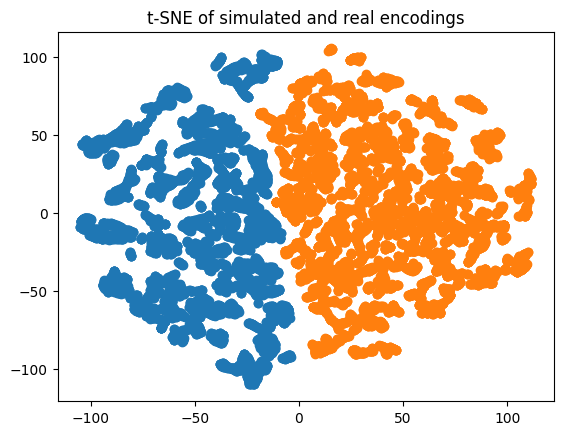

In [75]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sim_encodings = np.array(sim_encodings)
real_encodings = np.array(real_encodings)
mixed_encodings = np.concatenate((sim_encodings, real_encodings), axis=0)

tsne = TSNE(n_components=2, random_state=42)
# sim_X_2d = tsne.fit_transform(sim_encodings)
# real_X_2d = tsne.fit_transform(real_encodings)
mixed_encodings_X_2d = tsne.fit_transform(mixed_encodings)

sim_reduction = mixed_encodings_X_2d[:len(sim_encodings)]
real_reduction = mixed_encodings_X_2d[len(sim_encodings):]

# plt.scatter(sim_X_2d[:, 0], sim_X_2d[:, 1])
# plt.scatter(real_X_2d[:, 0], real_X_2d[:, 1])
# plt.scatter(mixed_encodings_X_2d[:, 0], mixed_encodings_X_2d[:, 1])
plt.scatter(sim_reduction[:, 0], sim_reduction[:, 1], label='simulated')
plt.scatter(real_reduction[:, 0], real_reduction[:, 1], label='real')
plt.title('t-SNE of simulated and real encodings')
plt.show()

In [79]:
example_real = real_dataset[0]['img']
example_real = example_real.unsqueeze(0)
cond = model.encode(example_real.to(device))
xT = model.encode_stochastic(example_real.to(device), cond, T=1000)

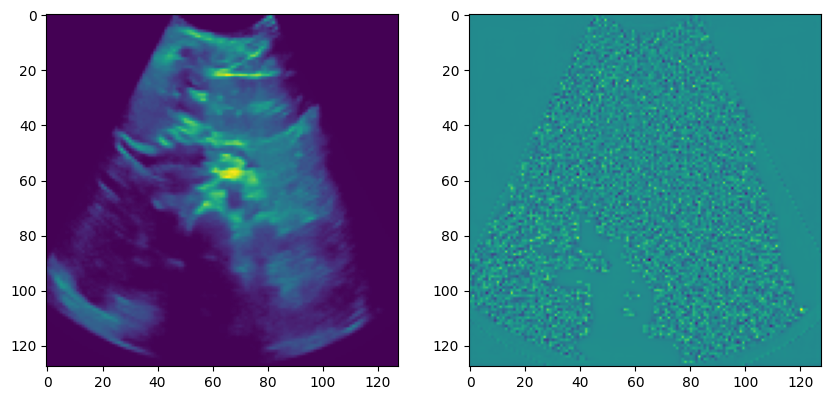

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(real_dataset[0]['img'].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

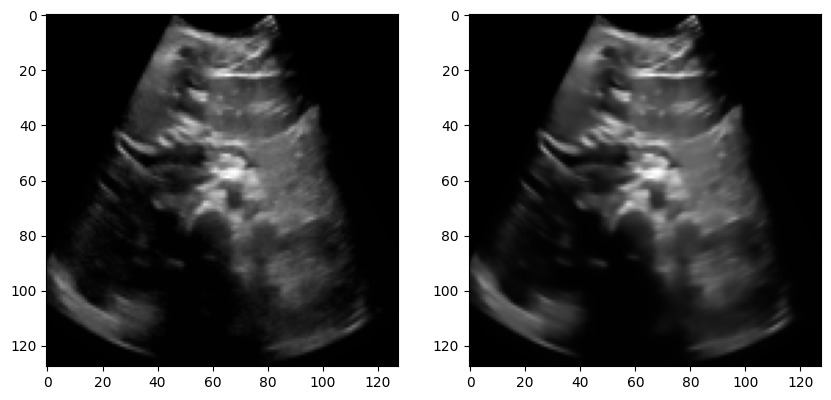

In [81]:
pred = model.render(xT, cond, T=1000)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(real_dataset[0]['img'].permute(1, 2, 0).cpu(), cmap='gray')
ax[1].imshow(pred[0].permute(1, 2, 0).cpu(), cmap='gray')

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(sim_encodings, real_encodings)

most_similar_indices = np.unravel_index(np.argmax(similarity_matrix, axis=None), similarity_matrix.shape)

most_similar_vector1 = sim_encodings[most_similar_indices[0]]
most_similar_vector2 = real_encodings[most_similar_indices[1]]

print('most similar indices: ', most_similar_indices)

most similar indices:  (5378, 5831)


In [61]:
def visualize_image_pair(sim_index, real_index):
    sim_img = simulated_dataset[sim_index]['img']
    real_img = real_dataset[real_index]['img']
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(sim_img.permute(1, 2, 0).cpu(), cmap='gray')
    ax[1].imshow(real_img.permute(1, 2, 0).cpu(), cmap='gray')
    plt.show()

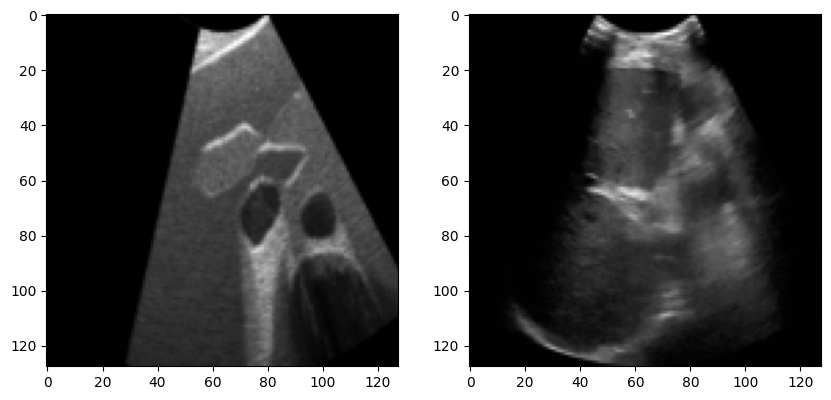

In [62]:
visualize_image_pair(most_similar_indices[0], most_similar_indices[1])

In [89]:
def interpolate_between_sim_real(sim_index, real_index):
    sim_img = simulated_dataset[sim_index]['img']
    real_img = real_dataset[real_index]['img']
    imgs = torch.stack([
        sim_img,
        real_img
    ])

    conds = model.encode(imgs.to(device))
    # real_cond = model.encode(real_img.to(device))
    # conds = torch.stack((sim_cond, real_cond)).to(device)

    xT = model.encode_stochastic(imgs.to(device), conds, T=1000)

    alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(conds.device)
    intp = conds[0][None] * (1 - alpha[:, None]) + conds[1][None] * alpha[:, None]

    def cos(a, b):
        a = a.view(-1)
        b = b.view(-1)
        a = F.normalize(a, dim=0)
        b = F.normalize(b, dim=0)
        return (a * b).sum()

    theta = torch.arccos(cos(xT[0], xT[1]))
    x_shape = xT[0].shape
    intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
    intp_x = intp_x.view(-1, *x_shape)

    pred = model.render(intp_x, intp, T=1000)
    fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
    for i in range(len(alpha)):
        ax[i].imshow(pred[i].permute(1, 2, 0).cpu(), cmap='gray')

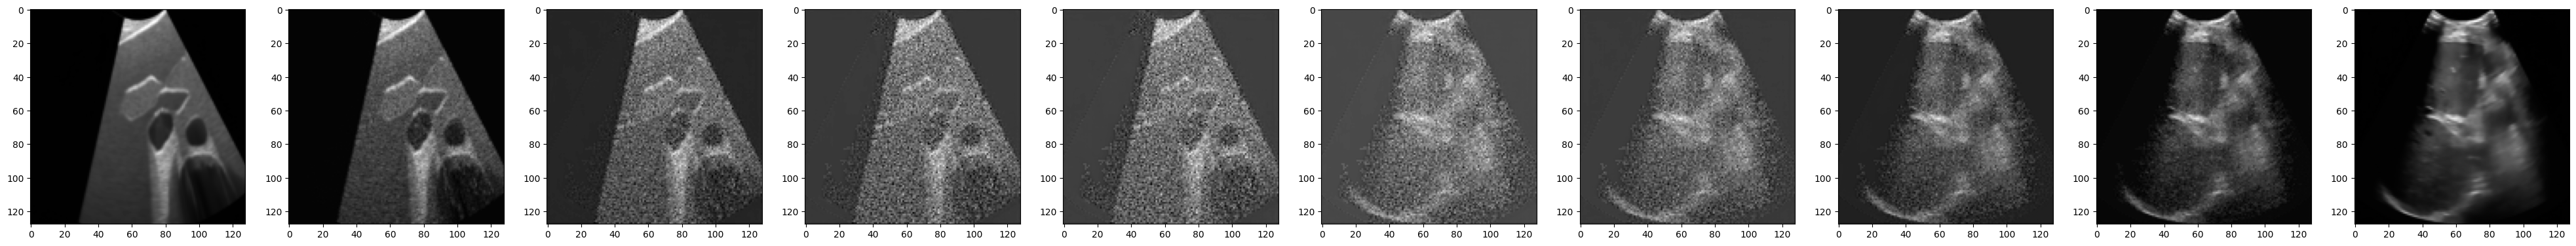

In [91]:
interpolate_between_sim_real(most_similar_indices[0], most_similar_indices[1])